# **Point Net - Classification**

In [1]:
import os
import re
from glob import glob
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics.classification import MulticlassMatthewsCorrCoef
import open3d as o3

from open3d.web_visualizer import draw # for non Colab
import os, os.path as osp

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

## Now: feature extraction of the foils

In [3]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import warnings
from point_net import PointNetClassHead
from shapely.geometry import Polygon
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm

from analyze_pointnet_backbone import analyze_pointnet_backbone

plots = False
  

### cls_model_35

In [4]:
out35 = analyze_pointnet_backbone('trained_models/cls_focal_clr/cls_model_35.pth',DEVICE, plots)

[cls_model_35] Model loaded from: trained_models/cls_focal_clr/cls_model_35.pth
[cls_model_35] Collected features: X=(1000, 1024), labels=(1000,)


### cls_model_37

In [5]:
out37 = analyze_pointnet_backbone('trained_models/cls_focal_clr/cls_model_37.pth',DEVICE, plots)

[cls_model_37] Model loaded from: trained_models/cls_focal_clr/cls_model_37.pth
[cls_model_37] Collected features: X=(1000, 1024), labels=(1000,)


### cls_model_38

In [6]:
out38 = analyze_pointnet_backbone('trained_models/cls_focal_clr/cls_model_38.pth',DEVICE, plots)

[cls_model_38] Model loaded from: trained_models/cls_focal_clr/cls_model_38.pth
[cls_model_38] Collected features: X=(1000, 1024), labels=(1000,)


### cls_model_15

In [7]:
out15 = analyze_pointnet_backbone('trained_models/cls_focal/cls_model_15.pth',DEVICE, plots)

[cls_model_15] Model loaded from: trained_models/cls_focal/cls_model_15.pth
[cls_model_15] Collected features: X=(1000, 1024), labels=(1000,)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.012s...
[t-SNE] Computed neighbors for 1000 samples in 0.073s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.028195
[t-SNE] KL divergence after 250 iterations with early exaggeration: 105.199074
[t-SNE] KL divergence after 1000 iterations: 2.664427
[Raw (x,y) t-SNE computed: X2_raw=(1000, 2)


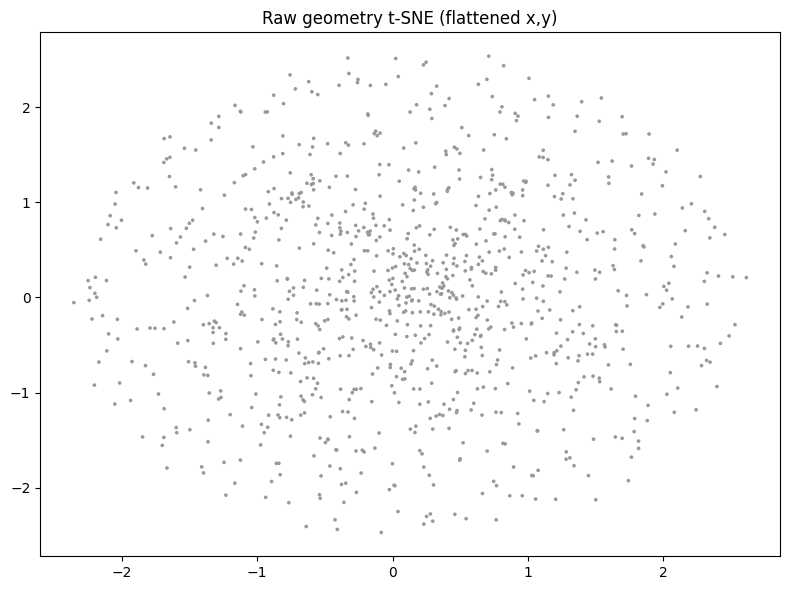

In [8]:
    
# ------------------------------------------------------------------------------- t-SNE on raw (x,y) coordinates — no preprocessing
from torch.utils.data import DataLoader
from shapenet_dataset import ShapenetDataset    
ROOT = osp.abspath("shapenet_like_out")
npoints = 10000
BATCH_SIZE = 32
test_dataset = ShapenetDataset(ROOT, npoints=npoints, split='test', classification=True, normalize=False) #already normalized in convert_to_shapenet_like, see later if we keep it like that or not
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)    

N = len(test_dataset)
NPTS = getattr(test_dataset, "npoints", None)

# Build raw feature matrix by simple flattening of (x,y)
raw_xy = np.empty((N, 2 * NPTS), dtype=np.float32)
for i in range(N):
    pts, _ = test_dataset[i]                  # (NPTS, 3) tensor
    pts = np.asarray(pts)
    xy = pts[:, :2].reshape(-1)               # (2*NPTS,)
    raw_xy[i] = xy

tsne_raw = TSNE(
    n_components=2,
    metric='cosine',
    init='pca', # t is highly recommended to use another dimensionality reduction method (e.g. PCA for dense data or TruncatedSVD for sparse data)
    learning_rate='auto',
    perplexity=30, #  Consider selecting a value between 5 and 50
    verbose=1
)
X2_raw = tsne_raw.fit_transform(raw_xy)
print(f"[Raw (x,y) t-SNE computed: X2_raw={X2_raw.shape}")

# Plot (neutral)
plt.figure(figsize=(8, 6))
plt.scatter(X2_raw[:, 0], X2_raw[:, 1], s=7, color=(0.6, 0.6, 0.6), edgecolors='none')
plt.title(f'Raw geometry t-SNE (flattened x,y)')
plt.tight_layout()
plt.show()
